In [1]:
%load_ext autoreload
%autoreload 2

# Chemistry and CO synthetic observations

This script focus on reading and analysing the chemistry and CO emission line obtained from post-processing the TIGRESS simulations ([Gong et al 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...858...16G/abstract), [Gong et al. 2020](https://ui.adsabs.harvard.edu/abs/2020ApJ...903..142G/abstract)). 

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import gridspec
import numpy as np
import yt #https://yt-project.org/

## Load the simulation model

In [3]:
# Need to set the master directory where the data is stored
dir_master = "../data/"
# name of the simulation model
model_id = "R8_2pc" 

First we need to load the simulation, and look at what snapshots and datasets are available. See the **Examing the simulation model information** section in *read_data_1-MHD.ipynb* for more details.

In [4]:
# add path to astro_tigress module
# this can also be done using PYTHONPATH environment variable
import sys
sys.path.insert(0,'../')

import astro_tigress
model = astro_tigress.Model(model_id,dir_master) #reading the model information
print("Snapshots and contained data sets:")
for ivtk in model.ivtks:
    print("ivtk={:d}, t={:.1f} Myr, datasets={}".format(ivtk, ivtk*model.dt_Myr, model.data_sets[ivtk]))

Snapshots and contained data sets:
ivtk=290, t=283.6 Myr, datasets=['CO_lines', 'MHD', 'chem']


## Read and analyse the chemistry output

Now, we want to look into the detailed chemistry data of the simulations. This is the chemistry post-processing output from the Athena++ HDF5 output file.

First, we select a snapshot (identified by its ivtk number) and the type of dataset we want to look into ("chem" in this case). Then we need to load the data. Because the data files are large, it can take a while to load.

**Download the data if you haven't done it yet**

* [Globus](https://app.globus.org/file-manager?origin_id=dc43f461-0ca7-4203-848c-33a9fc00a464&origin_path=%2Fackh-7y71%2F)
* You can navigate the folder and only download selected snapshots.
* You will always need `histroy` and `input` files. You can run the following. 
```
    model.download(dataset=["history","input"])
    model = astro_tigress.Model(model_id,dir_master) # need to reload the class
```

In [5]:
#load the chemistry data set for the snapshot ivtk=300
model.load(290, dataset="chem")

You can print out the information of all the fields available using the code below (I commented it because the output is too long). 

In [6]:
#model.chem.ytds.field_info

Let's start with reading the $\mathrm{H_2}$ abundance:

In [7]:
xH2 = model.chem.grid["H2"]
print("Check the type of the variable: ", type(xH2))

Check the type of the variable:  <class 'unyt.array.unyt_array'>


Because we use the python package [YT](https://yt-project.org/) to read the data, all fields are YT arrays that have units attached (see *read_data_1-MHD.ipynb* for more details). The H2 abundance is dimensionless. Still, you may want to convert it into a numpy array.

In [8]:
xH2_np = xH2.value
print("Check the type of the variable: ", type(xH2_np))

Check the type of the variable:  <class 'numpy.ndarray'>


We can multiply xH2 by the number density of hydrogen nuclei to obtain the number density of H2 molecule.

In [9]:
nH_np = model.chem.grid["nH"].in_units("cm**-3").value
nH2_np = nH_np * xH2_np

Below is a histogram of the H2 moleclue number density, for the cell where $n_\mathrm{H_2} > 1~\mathrm{cm^{-3}}$.

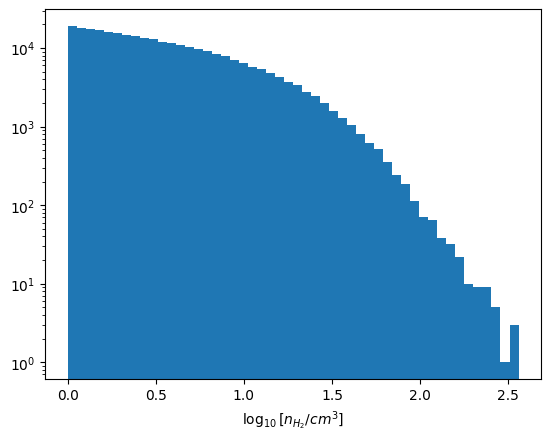

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
indx = nH2_np.reshape(-1) > 1.
ax.hist(np.log10(nH2_np.reshape(-1)[indx]), bins=50)
ax.set_yscale("log")
ax.set_xlabel(r"$\log_{10}[n_{H_2} / cm^3]$");

Here is an example of plotting the column density of H2 molecules.

In [11]:
NH2 = model.chem.get_col("H2").in_units("cm**-2")

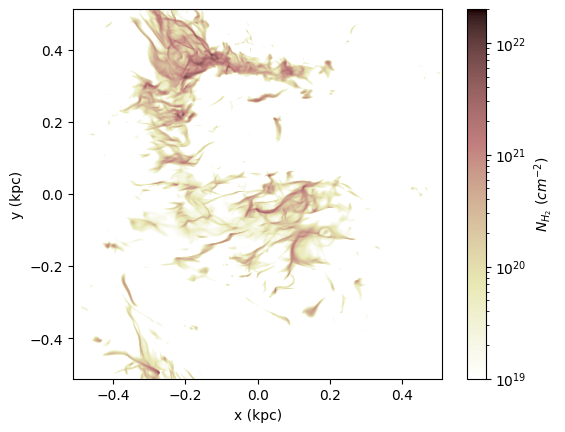

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
keys_NH2 = {"origin":"lower", "cmap":"pink_r", "norm": LogNorm(vmin=1e19, vmax=2e22)}
left_edge_kpc = model.chem.grid.left_edge.in_units("kpc").value
right_edge_kpc = model.chem.grid.right_edge.in_units("kpc").value
extent = [left_edge_kpc[0], right_edge_kpc[0], left_edge_kpc[1], right_edge_kpc[1]]
cax = ax.imshow(np.swapaxes(NH2, 0, 1), extent=extent,  **keys_NH2)
cbar = fig.colorbar(cax)
ax.set_xlabel("x (kpc)")
ax.set_ylabel("y (kpc)")
cbar.set_label(r"$N_{H_2}\ (cm^{-2})$")

## Read and analyse the CO emission lines output

In [13]:
#load the CO line dataset for the snapshot ivtk=290
model.load(290, dataset="CO_lines", iline=1) #CO(J=1-0)
model.load(290, dataset="CO_lines", iline=2) #CO(J=2-1)

Below is an example figure of CO (1-0) and (2-1) lines. Comparing to the H2 map above, you can see that CO traces denser gas than H2.

In [14]:
#setting the range of x and y axes
model.load(290, dataset="MHD")
left_edge_kpc = model.MHD.grid.left_edge.in_units("kpc").value
right_edge_kpc = model.MHD.grid.right_edge.in_units("kpc").value
extent = [left_edge_kpc[0], right_edge_kpc[0], left_edge_kpc[1], right_edge_kpc[1]]

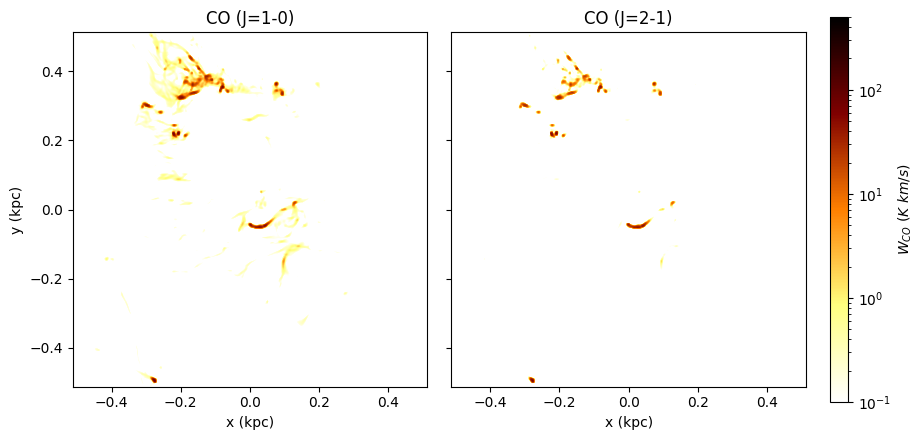

In [15]:
fig = plt.figure(figsize=[10, 5])
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.1)
ax1 = fig.add_subplot(gs[0, 0], aspect="equal")
ax2 = fig.add_subplot(gs[0, 1], aspect="equal")
ax_cbar = fig.add_subplot(gs[0, 2])
keys_WCO = {"origin":"lower", "cmap":"afmhot_r", "norm": LogNorm(vmin=0.1, vmax=500)}
cax = ax1.imshow(np.swapaxes(model.CO_lines[1].WCO, 0, 1), extent=extent, **keys_WCO)
ax2.imshow(np.swapaxes(model.CO_lines[2].WCO, 0, 1), extent=extent, **keys_WCO)
ax1.set_title("CO (J=1-0)")
ax2.set_title("CO (J=2-1)")
cbar = fig.colorbar(cax, cax=ax_cbar)
cbar.set_label(r"$W_{CO}\ (K\ km/s)$")
ax1.set_xlabel("x (kpc)")
ax2.set_xlabel("x (kpc)")
ax1.set_ylabel("y (kpc)")
ax2.set_yticklabels([]);

Finally, if you'd rather use **FITS files**, we have a function to output the PPV cubes into FITS files!

The commands below will save the CO (1-0) line PPV cube into a FITS file. Give it a try!

In [16]:
#model.CO_lines[1].img.write_fits(fn_fits="CO1-0.fits")